# Preparation
First, you'll need to download the Spacy NLP library. Run the next cell to install Spacy, then **RESTART the COLAB RUNTIME by clicking on the menu Runtime - Restart runtime.**

In [ ]:
# Download Spacy tokenizers
#!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

# Need to restart Colab Runtime

     |████████████████████████████████| 12.0 MB 4.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.7 MB 5.0 MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727025 sha256=c5c608112a1838ff85dcbd39dda715c38532a4568b479f986e864fc2c0ab1f0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5i3izlmo/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c24
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


# Restart Colab Runtime
Click menu Runtime - Restart runtime

# IWSLT2016 Dataset

In [ ]:
import torch, torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IWSLT2016
from typing import Iterable, List
import numpy as np

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchText Version: {torchtext.__version__}")

PyTorch Version: 1.10.0+cu111
TorchText Version: 0.11.0


# ERROR ALERT:
*   You may receive a **"RuntimeError: Internal error: confirm_token was not found in Google drive link."** in the cell below.
*   This is a recent error in Torchtext 0.11.0 due to the dataset URL changing and/or changes to requests library.
* We are trying to find a workaround.


# Code that follows remains for illustrative purposes.

# WARNING:
If you get an error running the next cell, it's probably because you didn't restart the runtime in step 1.

In [ ]:
train_iter = IWSLT2016(split=('train'), 
                       language_pair=('en','fr'))

In [ ]:
tokenizer_en = get_tokenizer('spacy',language='en_core_web_sm')
tokenizer_fr = get_tokenizer('spacy',language='fr_core_news_sm')

In [ ]:
%%time
sent_len_en = []
sent_len_fr = []
iter_len = 0
for en_sent, fr_sent in train_iter:
  sent_len_en.append(len(tokenizer_en(en_sent)))
  sent_len_fr.append(len(tokenizer_fr(fr_sent)))
  iter_len += 1
print(f'Dataset contains {iter_len} sentences.')


Dataset contains 220400 sentences.
CPU times: user 1min 8s, sys: 355 ms, total: 1min 8s
Wall time: 1min 8s


## Check sentence lengths in dataset
Are the buckets sizes good?

In [ ]:
bucket_sizes = [(5, 10), (10, 15), (20, 25), (40, 50)]

2 754
2 887


(array([29694., 85086., 51610., 27633., 13436.,  6483.,  3045.,  1559.,
          803.,   422.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

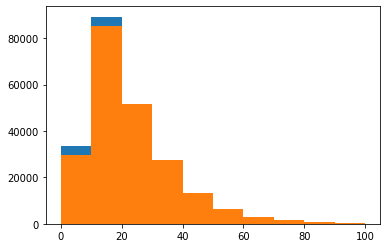

In [ ]:
import matplotlib.pyplot as plt
print(np.array(sent_len_en).min(), np.array(sent_len_en).max())
plt.hist(sent_len_en, range=(0,100))

print(np.array(sent_len_fr).min(), np.array(sent_len_fr).max())
plt.figure
plt.hist(sent_len_fr, range=(0,100))

# Create Vocabularies (en, fr)

In [ ]:
def yield_tokens(data_iter, language):
    if language == 'en':
      for data_sample in data_iter:
          yield tokenizer_en(data_sample[0])
    else:
      for data_sample in data_iter:
        yield tokenizer_fr(data_sample[1])

UNK_IDX, PAD_IDX, GO_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<go>', '<eos>']

# Create Vocabs
train_iter = IWSLT2016(root='.data', split=('train'), 
                             language_pair=('en', 'fr'))

vocab_en = build_vocab_from_iterator(
                  yield_tokens(train_iter, 'en'),
                  min_freq=1,
                  specials=special_symbols,
                  special_first=True)

train_iter = IWSLT2016(root='.data', split=('train'), 
                             language_pair=('en', 'fr'))
vocab_fr = build_vocab_from_iterator(
                  yield_tokens(train_iter, 'fr'),
                  min_freq=1,
                  specials=special_symbols,
                  special_first=True)

100%|██████████| 188M/188M [00:01<00:00, 133MB/s]


In [ ]:
print(len(vocab_en), len(vocab_fr))

61911 81272


# Preprocess Data

In [ ]:
# Token processing:
#   source: pad and reverse
#   target: add GO, EOS, and pad

def process_tokens(source, target, bucket_sizes):
  # find bucket_index
  for i in range(len(bucket_sizes)+2):
    # truncate if we exhauset list of buckets
    if i >= len(bucket_sizes): 
      bucket = bucket_sizes[i-1]
      bucket_id = i-1
      if len(source) > bucket[0]:
        source = source[:bucket[0]]
      if len(target) > (bucket[1]-2):
        target = target[:bucket[1]-2]
      break

    bucket = bucket_sizes[i]
    if (len(source) < bucket[0]) and ((len(target)+1) < bucket[1]):
      bucket_id = i
      break
  
  source += ((bucket_sizes[bucket_id][0] - len(source)) * ['<pad>'])
  source = list(reversed(source))

  target.insert(0,'<go>')
  target.append('<eos>')
  target += (bucket_sizes[bucket_id][1] - len(target)) * ['<pad>']

  return vocab_en(source), vocab_fr(target), bucket_id

  # source_t = torch.tensor(vocab_en(source), dtype=torch.float32)
  # target_t = torch.tensor(vocab_fr(target), dtype=torch.float32)
  # return source_t, target_t, bucket_id

In [ ]:
# test process_tokens()
train_iter = IWSLT2016(split=('train'), language_pair=('en','fr'))
for sent_en, sent_fr  in train_iter:
  source, target, bucket_id = process_tokens(tokenizer_en(sent_en), 
                                  tokenizer_fr(sent_fr), 
                                  bucket_sizes)
  print(bucket_id, bucket_sizes[bucket_id])
  print(len(source), source)
  print(len(target),target)
  # print(source.shape, source)
  # print(target.shape,target)

  break


2 (20, 25)
20 [1, 1, 1, 1, 1, 1, 5, 6, 26234, 6842, 89, 13, 6, 26487, 2039, 15, 96, 55, 26234, 1518]
25 [2, 1696, 31203, 47, 182, 2265, 31468, 5, 52, 90, 7916, 31203, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def create_bucketed_datasets(data_iter, bucket_sizes, max_data_size=None):
  datasets = []
  for i in range(len(bucket_sizes)):
    datasets.append([])

  iter_len = 0
  for sent_en, sent_fr  in train_iter:
    source, target, bucket_id = process_tokens(tokenizer_en(sent_en), 
                                    tokenizer_fr(sent_fr), 
                                    bucket_sizes)
    datasets[bucket_id].append((source, target))
    iter_len += 1
    if max_data_size != None and iter_len > max_data_size:
      break
    #break
  print(f'Dataset contains {iter_len} sentences.')
  return datasets

In [ ]:
# test create_bucketed_datasets()
train_iter = IWSLT2016(split=('train'), language_pair=('en','fr'))
datasets = create_bucketed_datasets(train_iter, bucket_sizes)

Dataset contains 220400 sentences.


In [ ]:
for dataset in datasets:
  print(len(dataset), len(dataset[0][0]), len(dataset[0][1]))
datasets[0][0][1] # dataset, sample, token_list

2047 5 10
30789 10 15
87726 20 25
99838 40 50


[2, 194, 5, 6, 3, 1, 1, 1, 1, 1]

# Create Dataloaders for batching

In [ ]:
# When we get a batch, the data should be same bucket size
# Create separate Map-Style datasets based on bucket size
# Each dataset will have a separate Dataloader
from torch.utils.data import Dataset

class BucketedDataset(Dataset):
  def __init__(self, bucketed_dataset, bucket_size):
    super(BucketedDataset, self).__init__()
    self.length = len(bucketed_dataset)
    self.input_len = bucket_size[0]
    self.target_len = bucket_size[1]
    self.bucketed_dataset = bucketed_dataset

  def __getitem__(self, index):
    return (torch.tensor(self.bucketed_dataset[index][0], 
                         dtype=torch.float32),
            torch.tensor(self.bucketed_dataset[index][1], 
                         dtype=torch.float32))

  def __len__(self):
    return self.length


In [ ]:
bucketed_datasets = []
for i, dataset in enumerate(datasets):
  bucketed_datasets.append(BucketedDataset(dataset, 
                                           bucket_sizes[i]))
# for dataset in bucketed_datasets:
#   print(len(dataset))
#   print(dataset[0])

# Set up Dataloaders for batching

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dataloaders = []
for dataset in bucketed_datasets:
  dataloaders.append(DataLoader(dataset, 
                                batch_size=32, 
                                shuffle=True))

# Training

In [ ]:
import torch.nn as nn

class TranslateLSTM(nn.Module):
  def __init__(self):
    super(TranslateLSTM, self).__init__()
    self.layer = nn.Linear(10,1)

  def forward(self, x):
    return self.layer(x)

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = TranslateLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(source, target):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = loss_fn(outputs, inputs)
  loss.backward()
  optimizer.step()

  return loss, output

